# 演習5　U-Netを用いたセグメンテーション処理


## VOCdevkitのディレクトリ構成

    VOCdevkit                    # 
    └─ VOC2012                 # 
        ├─ Annotations         #  
        ├─ ImageSets           # 
        │   ├─ Action         # 
        │   ├─ Layout         # 
        │   ├─ Main           # 
        │   └─ Segmentation   # 
        ├─ JPEGImages          # 
        ├─ SegmentationClass   # 
        └─ SegmentationObject  # 

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os

## 使用画像について
`image = Image.open("image path")`で、パスから画像１枚をロードする。
Pascal VOCの画像データセットは（http://host.robots.ox.ac.uk/pascal/VOC/voc2012/ ）のDevelopment Kitからダウンロードできる（２GB）。

In [2]:
#演習の授業用にdropboxにアップロードしておきましたので、そこからデータセットをダウンロードします
import urllib.request 

url = "https://www.dropbox.com/s/xvz9746uyztyr4j/VOCdevkit.zip?dl=1" # 保存したいファイルのURLを指定 (dropboxのURLを指定する際は、最後のdl=0をdl=1に設定する)
save_name = "VOCdevkit.zip" # VOCdevkit.zipという名前で保存される。
 
# ダウンロードを実行
urllib.request.urlretrieve(url, save_name)

('VOCdevkit.zip', <http.client.HTTPMessage at 0x7fa17b48b320>)

In [3]:
#uploadしたzipファイルを解凍する
import zipfile
with zipfile.ZipFile("VOCdevkit.zip","r") as zip_ref:
    zip_ref.extractall("") #""の中にはディレクトリのpathが入る

RGB


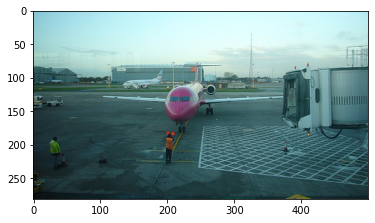

In [4]:
#画像の表示
#os.getcwd()はカレントディレクトリを取得
image = Image.open(os.getcwd() + "/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg")
plt.imshow(np.array(image))
print(image.mode)

イメージモードはP(パレットモード)


'\nclass Label:\n    GROUND = 0\n    AEROPLANE = 1\n    BICYCLE = 2\n    BIRD = 3\n    BOAT = 4\n    BOTTLE = 5\n    BUS = 6\n    CAR = 7\n    CAT = 8\n    CHAIR = 9\n    COW = 10\n    DINING_TABLE = 11\n    DOG = 12\n    HORSE = 13\n    MOTORBIKE = 14\n    PERSON = 15\n    POTTED_PLANT = 16\n    SHEEP = 17\n    SOFA = 18\n    TRAIN = 19\n    TV = 20\n    VOID = 255\n'

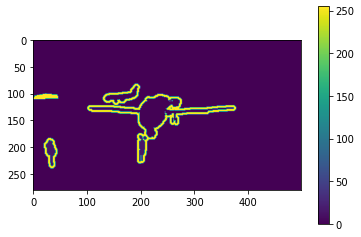

In [5]:
image = Image.open(os.getcwd() + "/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png")
plt.imshow(np.array(image))
plt.colorbar()
print("イメージモードは%s(パレットモード)" % image.mode)
"""
class Label:
    GROUND = 0
    AEROPLANE = 1
    BICYCLE = 2
    BIRD = 3
    BOAT = 4
    BOTTLE = 5
    BUS = 6
    CAR = 7
    CAT = 8
    CHAIR = 9
    COW = 10
    DINING_TABLE = 11
    DOG = 12
    HORSE = 13
    MOTORBIKE = 14
    PERSON = 15
    POTTED_PLANT = 16
    SHEEP = 17
    SOFA = 18
    TRAIN = 19
    TV = 20
    VOID = 255
"""
#バックグラウンド=0, 飛行機=1なのでほとんど同じ色に見える。VOID(枠線)のみ255ではっきり見える。

RGB


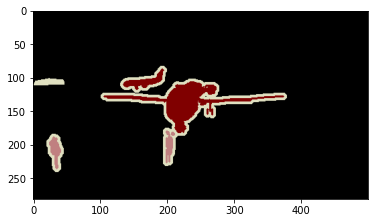

In [6]:
image = Image.open(os.getcwd() + "/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png")
image = image.convert("RGB")
plt.imshow(np.array(image))
print(image.mode)

## 使用画像の枚数構成の確認
 `map(lambda path: path.split(os.sep)[-1].split(".")[0], paths_segmented)`については「lambda式とmap.ipynb」を参照ください。

In [7]:
import os
import glob

dir_original = os.getcwd() + "/VOCdevkit/VOC2012/JPEGImages"
dir_segmented = os.getcwd() + "/VOCdevkit/VOC2012/SegmentationClass"

# globで指定ディレクトリ上のファイル全体のリストを作成
paths_original = glob.glob(dir_original + "/*")
paths_segmented = glob.glob(dir_segmented + "/*")

print("オリジナル画像は%s枚で、セグメント画像は%s枚" % (len(paths_original), len(paths_segmented)))

# セグメント画像が存在してオリジナルの存在しない画像をカウント
filenames = map(lambda path: path.split(os.sep)[-1].split(".")[0], paths_segmented) # セグメント画像の名前のイテレータ
non_existents = [name for name in filenames if not os.path.exists(dir_original+"/"+name+".jpg")] # オリジナルに存在しない画像名のリスト
print("セグメント画像が存在してオリジナルの存在しない画像は%s枚" % len(non_existents))

# オリジナル画像が存在してセグメント画像の存在しない画像をカウント
filenames = map(lambda path: path.split(os.sep)[-1].split(".")[0], paths_original)
non_existents = [name for name in filenames if not os.path.exists(dir_segmented+"/"+name+".png")]
print("オリジナル画像が存在してセグメント画像の存在しない画像は%s枚" % len(non_existents))

オリジナル画像は17125枚で、セグメント画像は2913枚
セグメント画像が存在してオリジナルの存在しない画像は0枚
オリジナル画像が存在してセグメント画像の存在しない画像は14212枚


## 3.使用するオリジナル画像とセグメント画像のパスのリストを作成する関数

 - セグメントリストのn番目の要素が、オリジナルリストのn番目をセグメントしたものに一致するように実装する。
 - セグメント画像の存在しないオリジナル画像を読み込まないようにする。
 - なお、オリジナルの存在しないセグメント画像については0枚だったので考慮しなくて良い。

In [8]:
import glob
import os

def generate_paths(dir_original: str, dir_segmented: str):
    '''
    dir_original: オリジナル画像のディレクトリ
    dir_segmented: セグメント画像のディレクトリ
    '''
    # globで指定ディレクトリ内のファイルのパス(フルパス)のリストを得る。
    paths_original = glob.glob(dir_original + "/*")
    paths_segmented = glob.glob(dir_segmented + "/*")

    # 指定ディレクトリが空ならエラーを出す。
    if len(paths_original) == 0 or len(paths_segmented) == 0:
        raise FileNotFoundError("Could not load images.")
        
    # オリジナル画像とセグメント画像がペアになってる画像データのパスのリストを作成
    filenames = list(map(lambda path: path.split(os.sep)[-1].split(".")[0], paths_segmented)) #セグメント画像のファイル名のみリストとして取得(拡張子は含まない)
    paths_original = list(map(lambda filename: dir_original + "/" + filename + ".jpg", filenames)) #セグメント画像のペアがあるオリジナル画像のpathをリストとして取得(拡張子含む)

    return paths_original, paths_segmented

## 4.使用するファイルのパスの取得
３で作った関数を用いてファイルパスを取得

In [9]:
images_original, images_segmented = [], []
dir_original = os.getcwd() + "/VOCdevkit/VOC2012/JPEGImages"
dir_segmented = os.getcwd() + "/VOCdevkit/VOC2012/SegmentationClass"
paths_original, paths_segmented = generate_paths(dir_original, dir_segmented)

## 5.訓練とテストに分割(scikit learnのtrain_test_splitを使用する)

In [10]:
from sklearn.model_selection import train_test_split
(train_original, test_original,
 train_segmented, test_segmented) = train_test_split(paths_original, paths_segmented, test_size=0.3) #test_size=0.3なので訓練データ：テストデータ　＝７：３

In [11]:
# オリジナルとセグメントの名前を確認
print(test_original[0])
print(test_segmented[0])

/content/VOCdevkit/VOC2012/JPEGImages/2011_003121.jpg
/content/VOCdevkit/VOC2012/SegmentationClass/2011_003121.png


In [12]:
len(test_original)

874

## 6.学習に使う画像を準備する

- オリジナル画像（入力画像）:  RGBなので3チャネル。バッチのshapeは(data_size, width, height, 3)としたい。
- セグメント画像（教師画像）: 背景/voidを含む22クラスのone-hotベクトル。バッチのshapeは(data_size, width, height, 22)としたい。

入力画像については簡単。PIL.Imageで読み込み、numpy.arrayへ変換すればよい。

教師画像をone-hot化したい。

#### 前処理
セグメント画像のクラスは22クラスあるが、voidのclass indexは255になっている。これを21に置換する。

(実装方法)

```python
np.where(array==255, 21, array)
```
によって、クラスインデックス255を21に置換した配列を得られる。


`np.where`は第一引数に抽出したい要素の条件を指定し、第二引数以降で条件を満たすときの値と満たさないときの値を指定することができる。

(例)

```python
a = np.arange(0, 10, 1)
print(a)
np.where( a%2 == 0, 'even', 'odd') # 偶数ならeven,奇数ならoddと返す。
```

### identity matrixを使ったOne hotベクトル化

##### one-hotベクトル化
例えば3クラス分類問題なら、クラス0を[1,0,0]、クラス1を[0,1,0]、クラス2を[0,0,1]と見做す。

セグメント画像として左のような2次配列が与えられたとき、one-hot化によって右のような3次配列に変換される。

\begin{align*}
\begin{bmatrix}
0 & 1 & 1 & 1 \\
1 & 1 & 1 & 0 \\
2 & 0 & 1 & 1 \\
2 & 2 & 2 & 1
\end{bmatrix}
\overset{\text{one-hot}}{\rightarrow}
\begin{bmatrix}
[1,0,0] & [0,1,0] & [0,1,0] & [0,1,0] \\
[0,1,0] & [0,1,0] & [0,1,0] & [1,0,0] \\
[0,0,1] & [1,0,0] & [0,1,0] & [0,1,0] \\
[0,0,1] & [0,0,1] & [0,0,1] & [0,1,0]
\end{bmatrix}
\end{align*}

(各点のベクトルは、(元の2次配列の軸「縦」「横」に対して)新たな軸「高さ」の方向に伸びる。)

###### one-hotへの変換方法

nクラスの分類問題の場合: サイズnのidentity matrixのi行目は、クラスiを表すone-hotのベクトルである。

`np.identity(n)[array]`で、arrayの各要素の整数がnクラスのone-hotベクトルに置き換えられた

(MNISTの実習では右のようにしてました。`Y_train = keras.utils.to_categorical(y_train, num_classes)`)

1次配列の場合、各要素がone-hotのベクトルに置き換わって、2次配列になる。(下のコード参照)

In [13]:
import pprint
vec = [0, 1, 2, 1, 3]
one_hot = np.identity(5)[vec]
pprint.pprint(vec)
pprint.pprint(one_hot)

[0, 1, 2, 1, 3]
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])


2次配列の場合も同様にして出来る。

In [14]:
matrix = np.array([[1, 1, 0],[0, 1, 2],[2, 0, 0]])
one_hot = np.identity(3)[matrix]
pprint.pprint(matrix)
pprint.pprint(one_hot)

array([[1, 1, 0],
       [0, 1, 2],
       [2, 0, 0]])
array([[[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]]])


以上を踏まえてデータ読み込みのための諸関数を定義する。

 - crop_center : 画像の中心から指定された幅,高さの矩形を切り出す関数。
 - crop_max_square : 画像の中心から短辺の長さの正方形を切り出す関数。
 - _load_image_from_npy : 指定されたパスの画像を読み込み、指定サイズのnumpy.arrayに変換して返す関数。
 - image_generator : 学習用のミニバッチを作成するジェネレータ。

In [15]:
#自作のimage genearatorを作って画像の前処理をする
"""
VOC2012のデータはそれぞれ画像のサイズが異なります．ですから，今回は各画像を正方形にcrop(切り抜き)し，
所定のサイズにリサイズすることで対処します．まとめると以下の4点ですね．
(今回のデータセットでは大丈夫ですが，アルファチャネルを持つ画像の場合意図せずshapeが4chになってしまうため，念の為除去．)
"""
import numpy as np
from PIL import Image

#画像の中心から短辺の長さの正方形を切り出す関数
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))


# 指定されたパスの画像を読み込み、指定サイズのnumpy.arrayに変換して返す関数
def _load_image_to_npy(file_path, init_size=(256,256), antialias=False, normalization=True, convertRGB=False):
    """
    Args:
        file_path : 画像ファイルのパス
        init_size : 出力サイズ(元画像より小さいとき画像はクロップされる)
        antialias : アンチエイリアス処理の有無
        normalization : 正規化の有無
        convertRGB : 画像モードをRGBにしてからnumpyに変換するか否か(セグメント画像をそのまま表示するために使う)
    """
    # open a image
    image = Image.open(file_path)
    # to square
    image = crop_max_square(image)
    # resize by init_size
    if init_size is not None and init_size != image.size:
        if antialias:
            image = image.resize(init_size, Image.ANTIALIAS)
        else:
            image = image.resize(init_size)

    # delete alpha channel
    if image.mode == "RGBA":
        image = image.convert("RGB")
        
    # 画像モードをRGBへ変更(パレットモード画像をそのままRGB画像にする処理)
    # 教師画像を学習に使うときにこの処理を使用してはいけない。
    if convertRGB:
        image = image.convert("RGB")

    #PILオブジェクトをnumpyにキャストしてから正規化
    image = np.asarray(image) 
    if normalization:
        image = image / 255.0
    return image

#generator
def image_generator(_paths_original, _paths_segmented, init_size=None, batch_size=32, shuffle=True):
    """
    `A generator which yields images deleted an alpha channel and resized.
        アルファチャネル削除、リサイズ(任意)処理を行った画像のバッチを返します
    Args:
        paths_original, paths_segmented : オリジナルとセグメンテッドのパスリスト(original[i]とsegmented[i]を対応させること)
        init_size (tuple(int, int)): If having a value, images are resized by init_size.
        normalization (bool): If true, normalize images.
        antialias (bool): Antialias. (画像のエッジ部分のギザギザが目立たないようにする. )
    Yields:
        image (ndarray[width][height][channel]): Processed image
    """
    #オリジナル画像とセグメント画像のpathの数が同じであることを確認
    assert len(_paths_original) == len(_paths_segmented)
    
    # shuffleがTrueの場合はindexをシャッフルする
    if shuffle == True:
        index_array = np.random.permutation(len(_paths_original))
    else:
        index_array = np.arange(len(_paths_original))
    
    # index_arrayの順番にパスリストを並べ替える
    paths_original = [_paths_original[i] for i in index_array]
    paths_segmented = [_paths_segmented[i] for i in index_array]
    
    #バッチサイズ分のデータを格納する４次テンソルを作る
    batch_index = 0
    images_original = np.zeros((batch_size, init_size[0], init_size[1], 3))
    images_segmented = np.zeros((batch_size, init_size[0], init_size[1], 22))
    
    
    while 1:
        if batch_index % batch_size == 0:
            images_original = np.zeros((batch_size, init_size[0], init_size[1], 3))
            images_segmented = np.zeros((batch_size, init_size[0], init_size[1], 22))

        images_original[batch_index % batch_size] = _load_image_to_npy(paths_original[batch_index % len(paths_original)],init_size, antialias=True)
        tmp = _load_image_to_npy(paths_segmented[batch_index % len(paths_segmented)], init_size, normalization=False)
        tmp = np.where(tmp==255, 21, tmp)
        images_segmented[batch_index % batch_size] = np.identity(22, dtype=np.uint8)[tmp]

        batch_index += 1
        if batch_index % batch_size == 0:
            yield images_original,images_segmented
            
    ##### 上位のwhile 1:からyieldまでについて
    # 画像を読み込むごとに変数batch_indexが1増える。
    # batch_sizeで割り切れるとき、バッチサイズ分の画像が確保できたことになるのでここでyieldする。
    # yield後に再び呼び出される時、処理はyieldの直後から、すなわちwhile文の先頭からになる。
    # そのため、batch_indexは初期化されず、増えていく。
    # 一方_load_image_to_npyの第一引数がpaths_original[batch_index % len(paths_original)]になっている理由は、
    # ジェネレータの呼び出し回数がデータの数を上回ったときに、再び先頭に戻るようにするため。

## モデルの実装

In [16]:
#モデルの実装
from keras.models import *
from keras.layers import *
from keras import backend as keras

def unet(pretrained_weights = None, input_shape = (256, 256, 3)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(22, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    
    return model
#論文ではpaddingせず、画像サイズが小さくなる。

In [17]:
"""
#U-Netの前半をVGG16に変更し、転移学習を行うモデル
from keras.applications.vgg16 import VGG16
from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D ,Conv2DTranspose
from keras.layers.core import Activation
from keras.layers.merge import concatenate
from keras.layers.pooling import MaxPooling2D

def get_vgg_7conv(input_shape):
    img_input = Input(input_shape)
    vgg16_base = VGG16(input_tensor=img_input, include_top=False)
    for l in vgg16_base.layers:
        l.trainable = True
    conv1 = vgg16_base.get_layer("block1_conv2").output
    conv2 = vgg16_base.get_layer("block2_conv2").output
    conv3 = vgg16_base.get_layer("block3_conv3").output
    pool3 = vgg16_base.get_layer("block3_pool").output

    conv4 = Conv2D(384, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block4_conv1")(pool3)
    conv4 = Conv2D(384, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block4_conv2")(conv4)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(conv4)

    conv5 = Conv2D(512, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block5_conv1")(pool4)
    conv5 = Conv2D(512, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block5_conv2")(conv5)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(conv5)

    conv6 = Conv2D(512, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block6_conv1")(pool5)
    conv6 = Conv2D(512, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block6_conv2")(conv6)
    pool6 = MaxPooling2D((2, 2), strides=(2, 2), name='block6_pool')(conv6)

    conv7 = Conv2D(512, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block7_conv1")(pool6)
    conv7 = Conv2D(512, (3, 3), activation="relu", padding='same', kernel_initializer="he_normal",
                   name="block7_conv2")(conv7)

    up8 = concatenate([Conv2DTranspose(384, (3, 3), activation="relu", kernel_initializer="he_normal",
                                       strides=(2, 2), padding='same')(conv7), conv6], axis=3)
    conv8 = Conv2D(384, (3, 3), activation="relu", kernel_initializer="he_normal", padding='same')(up8)

    up9 = concatenate([Conv2DTranspose(256, (3, 3), activation="relu", kernel_initializer="he_normal",
                                       strides=(2, 2), padding='same')(conv8), conv5], axis=3)
    conv9 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding='same')(up9)

    up10 = concatenate([Conv2DTranspose(192, (3, 3), activation="relu", kernel_initializer="he_normal",
                                        strides=(2, 2), padding='same')(conv9), conv4], axis=3)
    conv10 = Conv2D(192, (3, 3), activation="relu", kernel_initializer="he_normal", padding='same')(up10)

    up11 = concatenate([Conv2DTranspose(128, (3, 3), activation="relu", kernel_initializer="he_normal",
                                        strides=(2, 2), padding='same')(conv10), conv3], axis=3)
    conv11 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding='same')(up11)

    up12 = concatenate([Conv2DTranspose(64, (3, 3), activation="relu", kernel_initializer="he_normal",
                                        strides=(2, 2), padding='same')(conv11), conv2], axis=3)
    conv12 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding='same')(up12)

    up13 = concatenate([Conv2DTranspose(32, (3, 3), activation="relu", kernel_initializer="he_normal",
                                        strides=(2, 2), padding='same')(conv12), conv1], axis=3)
    conv13 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding='same')(up13)

    conv13 = Conv2D(22, (1, 1))(conv13)
    conv13 = Activation("sigmoid")(conv13)
    model = Model(img_input, conv13)
    return model
"""

'\n#U-Netの前半をVGG16に変更し、転移学習を行うモデル\nfrom keras.applications.vgg16 import VGG16\nfrom keras.engine.topology import Input\nfrom keras.engine.training import Model\nfrom keras.layers.convolutional import Conv2D ,Conv2DTranspose\nfrom keras.layers.core import Activation\nfrom keras.layers.merge import concatenate\nfrom keras.layers.pooling import MaxPooling2D\n\ndef get_vgg_7conv(input_shape):\n    img_input = Input(input_shape)\n    vgg16_base = VGG16(input_tensor=img_input, include_top=False)\n    for l in vgg16_base.layers:\n        l.trainable = True\n    conv1 = vgg16_base.get_layer("block1_conv2").output\n    conv2 = vgg16_base.get_layer("block2_conv2").output\n    conv3 = vgg16_base.get_layer("block3_conv3").output\n    pool3 = vgg16_base.get_layer("block3_pool").output\n\n    conv4 = Conv2D(384, (3, 3), activation="relu", padding=\'same\', kernel_initializer="he_normal",\n                   name="block4_conv1")(pool3)\n    conv4 = Conv2D(384, (3, 3), activation="relu", padding=\'sam

## IoUの定義

In [18]:
"""
#作ったけど講義では使いません。
def IoU(y_true, y_pred):
    y_pred_seg = K.argmax(y_pred, axis=-1)
    y_pred_seg = K.one_hot(y_pred_seg, 22)
    eps = 1e-6
    if K.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred_seg) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred_seg, axis=[1,2,3]) #重なっている部分のピクセル数の計算（y_true　∩　y_pred）
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred_seg, axis=[1,2,3]) - intersection #（y_true　∪　y_pred）
    return K.mean((intersection + eps) / (union + eps), axis=0) #（y_true　∩　y_pred）/（y_true　∪　y_pred）
"""

'\n#作ったけど講義では使いません。\ndef IoU(y_true, y_pred):\n    y_pred_seg = K.argmax(y_pred, axis=-1)\n    y_pred_seg = K.one_hot(y_pred_seg, 22)\n    eps = 1e-6\n    if K.max(y_true) == 0.0:\n        return IoU(1-y_true, 1-y_pred_seg) ## empty image; calc IoU of zeros\n    intersection = K.sum(y_true * y_pred_seg, axis=[1,2,3]) #重なっている部分のピクセル数の計算（y_true\u3000∩\u3000y_pred）\n    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred_seg, axis=[1,2,3]) - intersection #（y_true\u3000∪\u3000y_pred）\n    return K.mean((intersection + eps) / (union + eps), axis=0) #（y_true\u3000∩\u3000y_pred）/（y_true\u3000∪\u3000y_pred）\n'

## モデルの宣言とコンパイル、サマリの確認

モデルを宣言し、optimizer、loss、metricsを指定してコンパイルする。

サマリを出力し、モデルの出力shapeのサイズやチャンネル数が期待通りかを確認する。

In [19]:
from keras.optimizers import *
from keras.metrics import MeanIoU
import tensorflow as tf

width, height = (256,256)
model = unet(input_shape=(width,height,3))
#model = vgg_7convs(input_shape=(width,height,3))

#metrics = [IoU]になっていることに注目。学習の際epoch毎にIoUを計算してくれる。
#model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = [IoU])
model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## モデルの学習

まず学習結果の重みの保存先ディレクトリを作成する。

In [20]:
import pathlib
pathlib.Path(os.getcwd()+"/unet_result").mkdir(exist_ok=True)
pathlib.Path(os.getcwd()+"/unet_result/saved_model").mkdir(exist_ok=True)

In [21]:
from keras.callbacks import ModelCheckpoint
batch_size=16
epochs=1
chk = ModelCheckpoint(os.getcwd()+"/unet_result/saved_model" + "/epoch{epoch:02d}.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
hist = model.fit_generator(image_generator(train_original, train_segmented, (width,height), batch_size=batch_size),
                           steps_per_epoch = len(train_original)//batch_size, #1epochで用いるminibatchの個数
                           epochs=epochs,
                           validation_data=image_generator(test_original, test_segmented, (width,height), batch_size=batch_size),
                           validation_steps=len(test_original)//batch_size+1,
                           workers=1, 
                           callbacks=[chk])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


127/127 [==============================] - 162s 1s/step - loss: 1.9137 - mean_io_u: 0.4773 - val_loss: 1.6690 - val_mean_io_u: 0.4773


## 学習結果を用いた予測

predict_generatorを用いてテスト画像の予測結果を取得。

45 epoch目の重みを配布しますので、それを使って予測を行います。

既にRAMをかなり使用してしまっているので、"ランタイム"から"ランタイムを再起動"を選んでください。

その後、一つ前の学習をこなうセル以外を実行して、以下のセルを実行ください。

(厳密には、実行するセルはもっと少なくても良いですが。)

In [22]:
#演習の授業用にdropboxにアップロードしておきましたので、そこからデータセットをダウンロードします
import urllib.request 

url = "https://www.dropbox.com/s/fejj0a8la0mwk2l/epoch45.h5?dl=1" # 保存したいファイルのURLを指定 (dropboxのURLを指定する際は、最後のdl=0をdl=1に設定する)
save_name = "epoch45.h5" # VOCdevkit.zipという名前で保存される。
 
# ダウンロードを実行
urllib.request.urlretrieve(url, save_name)

('epoch45.h5', <http.client.HTTPMessage at 0x7fa1349b9358>)

In [23]:
# 指定したepochの重みでモデルを用いる。
# このコードを実行しない場合、変数modelは最後のepochの重みを用いる。
epoch = 45
from keras.models import *
weight_path = os.getcwd() #+"/unet_result/saved_model
width, height = (256,256)
batch_size=8
model = load_model(weight_path+('/epoch%02d.h5' % epoch), compile=False)

予測結果を確認する。

 - predict_generatorの引数stepsはimage_generatorを呼び出す回数を表します。
 - image_generatorはbatch_size個のデータを返します。
 - つまり、predict_generatorの出力は、batch_size*steps枚の画像に対する出力結果です。

 (今回は予測結果のサイズが大きく、すべてのテストデータの予測結果を変数に代入するとcolaboratoryのRAM容量を超過してしまいます。ここではsteps=1として、先頭から8枚の画像の予測のみ行います。)

In [24]:
pred = model.predict_generator(image_generator(test_original, test_segmented, (width, height), batch_size=batch_size, shuffle=False), 
                               steps=1, 
                               max_queue_size=5, 
                               workers=1, 
                               use_multiprocessing=False, 
                               verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1/1 [==============================] - 2s 2s/step


テスト画像について次のコードで目視確認できます。

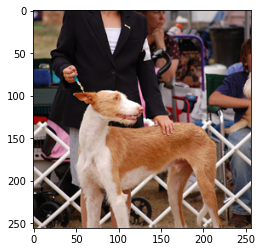

In [25]:
import matplotlib.pyplot as plt

i=1 # 確認したいテスト画像の番号

init_size=(256,256)
img=_load_image_to_npy(test_original[i], init_size, antialias=False, normalization=False)
plt.imshow(img)

### 予測結果、入力画像、真のセグメント画像をグリッド表示する関数

In [26]:
#(256,256,22)の配列の各ピクセルに対して最大値を取るクラス番号を計算して、それらで構成される(256,256)の配列を取得する

def segmentation(pred):
    """
    Args(引数): pred: 3次元のnumpy配列(channel lastとする)
    Returns: 2次元のnumpy配列で、各要素の整数は当該ピクセルのクラスを表す。
    """
#    return np.apply_along_axis(lambda array: np.argmax(array), 2, pred)
    return np.argmax(pred, axis=2)

##### セグメント画像用のカラーパレットの取得

In [27]:
# セグメント画像を一枚読み込みカラーパレットを取得する。
#https://teratail.com/questions/146307 が参考になります。

pil_img = Image.open(os.getcwd()+"/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png")
palette = pil_img.getpalette()
palette = np.array(palette).reshape(-1, 3)

##### 上のカラーパレットを使った予測結果の色付け表示

In [28]:
pred.shape

(8, 256, 256, 22)

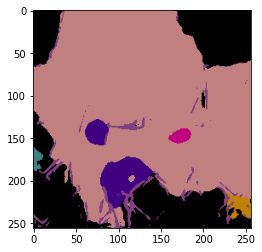

In [29]:
i=1
# セグメント結果を取得する。
seg = segmentation(pred[i]) #(256, 256)サイズのパレット画像が返ってくる。

# 先のカラーパレットを用いて、予測結果を色付けして表示する。(RGB画像が返る)
#segrgb = np.apply_along_axis(lambda array: np.apply_along_axis(lambda elem: palette[elem], 0, array), 1, seg)でも良い。
segrgb = np.zeros((256,256,3),dtype='uint8')
for n, array in enumerate(seg):
    for m, elem in enumerate(array):
        segrgb[n,m,:] = palette[elem]

plt.imshow(segrgb)

##### 予測結果のオーバーレイ表示

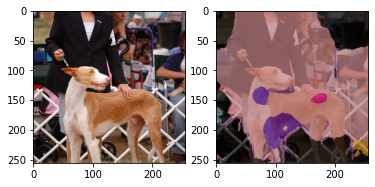

In [30]:
# オリジナル画像に予測結果をオーバーレイすることが出来る。

i=1
# セグメント結果を取得する。
seg = segmentation(pred[i])

# 先のカラーパレットを用いて、予測結果を色付けして表示する。
segrgb = np.apply_along_axis(lambda array: np.apply_along_axis(lambda elem: palette[elem], 0, array), 1, seg)

# オリジナル画像をnumpy.arrayとして読み込む。
original = _load_image_to_npy(test_original[i], (256,256))
plt.figure()
# 左側にはオリジナル画像
plt.subplot(1,2,1)
plt.imshow(original)
# 右側にはオーバーレイ
plt.subplot(1,2,2)
plt.imshow(original)
plt.imshow(segrgb, 'jet', alpha=0.7)
plt.show()

##### 結果をグリッド表示する関数

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

CATEGORY = (
        "ground",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "dining table",
        "dog",
        "horse",
        "motorbike",
        "person",
        "potted plant",
        "sheep",
        "sofa",
        "train",
        "tv/monitor",
        "void"
)

def func(pred, true_path, label_path):
    """
    予測結果たちをグリッド表示。
    Args:
        pred: 3次元のnumpy.array(予測結果)
        true_path: オリジナル画像のパス
        label_path: 真のセグメント画像のパス
    """
    
    plt.figure(figsize=(10, 8),dpi=200)
    gs = gridspec.GridSpec(4, 6)

    for j in range(22):
        plt.subplot(gs[j//6,j%6])
        plt.imshow(pred[:,:,j])
        plt.text(0, 0, CATEGORY[j], size=12)
        ax = plt.gca() # get current axis
        ax.spines["right"].set_color("none")  # 右消し
        ax.spines["left"].set_color("none")   # 左消し
        ax.spines["top"].set_color("none")    # 上消し
        ax.spines["bottom"].set_color("none") # 下消し
        plt.axis("off")

    img=_load_image_to_npy(true_path, init_size, antialias=False, normalization=False)
    plt.subplot(gs[22//6,22%6])
    plt.imshow(img)
    plt.text(0, 0, 'true', size=12)
    ax = plt.gca() # get current axis
    ax.spines["right"].set_color("none")  # 右消し
    ax.spines["left"].set_color("none")   # 左消し
    ax.spines["top"].set_color("none")    # 上消し
    ax.spines["bottom"].set_color("none") # 下消し
    plt.axis("off")

    
    img=_load_image_to_npy(label_path, init_size, antialias=False, normalization=False, convertRGB=True)
    plt.subplot(gs[23//6,23%6])
    plt.imshow(img)
    plt.text(0, 0, 'segmented', size=12)
    ax = plt.gca() # get current axis
    ax.spines["right"].set_color("none")  # 右消し
    ax.spines["left"].set_color("none")   # 左消し
    ax.spines["top"].set_color("none")    # 上消し
    ax.spines["bottom"].set_color("none") # 下消し
    plt.axis("off")
 
    plt.show()

## 実行結果

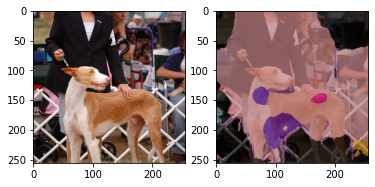

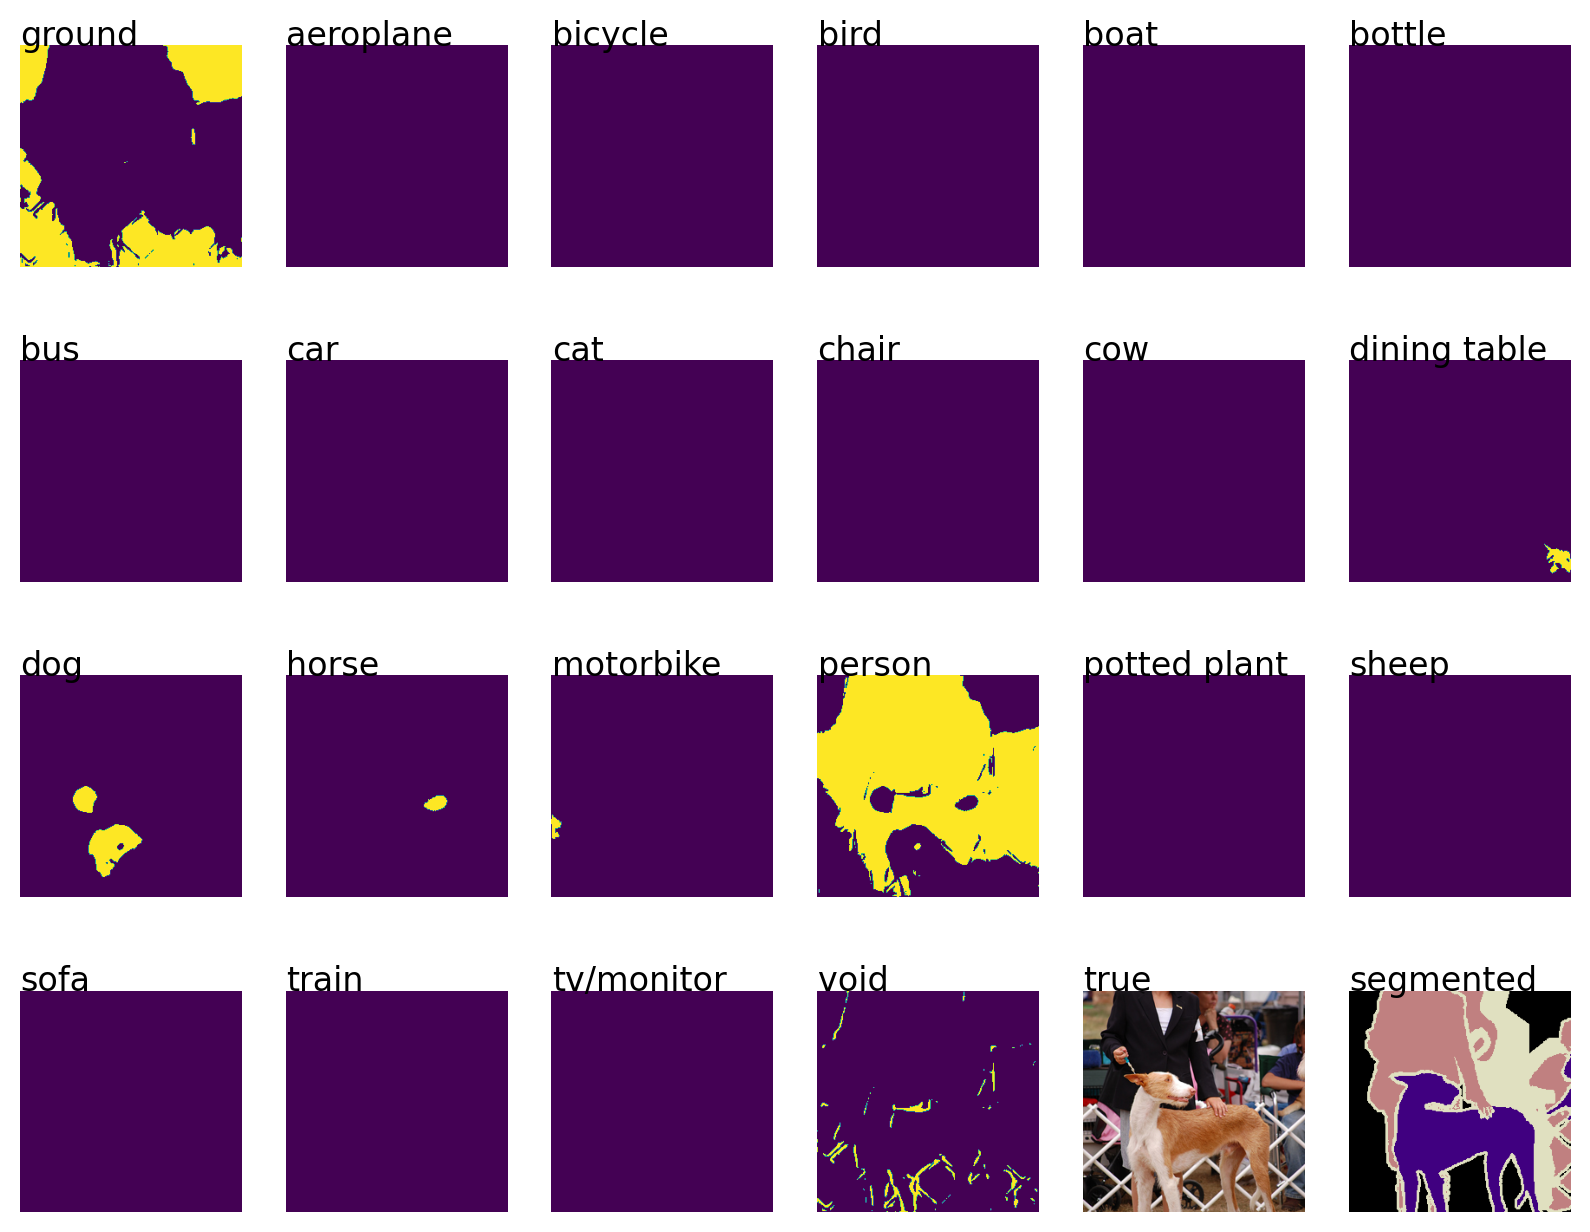

In [32]:
i=1 #ここの数字を変えて画像を変えてみてください。

# セグメント結果を取得する。
seg = segmentation(pred[i])
# one-hotに変換する。
seg_one_hot=np.identity(22, dtype=np.uint8)[seg]

# 先のカラーパレットを用いて、予測結果を色付けして表示する。
segrgb = np.apply_along_axis(lambda array: np.apply_along_axis(lambda elem: palette[elem], 0, array), 1, seg)

# オリジナル画像をnumpy.arrayとして読み込む。
original = _load_image_to_npy(test_original[i])
plt.figure()
plt.subplot(1,2,1)
plt.imshow(original)
plt.subplot(1,2,2)
plt.imshow(original)
plt.imshow(segrgb, 'jet', alpha=0.7)
plt.show()

# グリッド表示
func(seg_one_hot,test_original[i], test_segmented[i])

おまけ：8枚目までだけでなく、それ以降の画像の出力結果を確認したい場合には、例えば次のコードを実行すると良いでしょう。

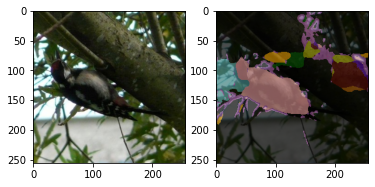

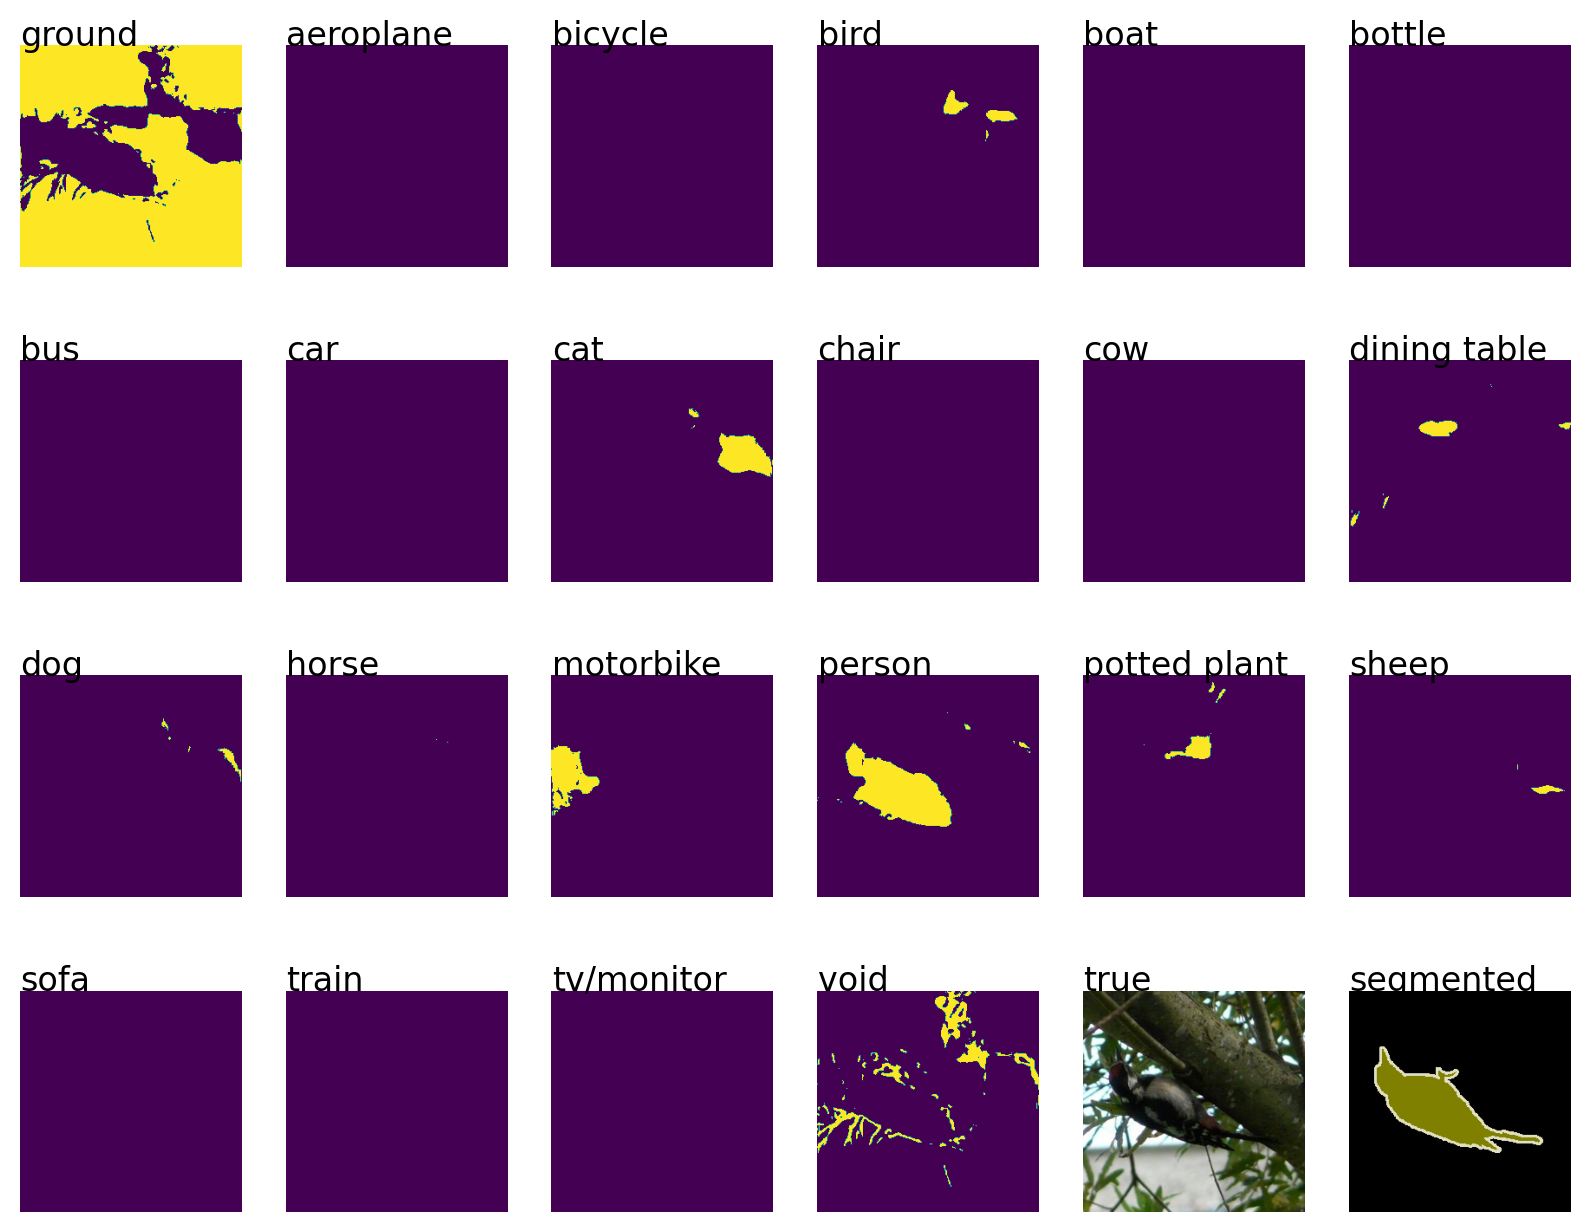

In [33]:
i = 2
assert i < len(test_original)

test_input = np.zeros((1, width, height, 3))
test_input[0] = _load_image_to_npy(test_original[i], antialias=True)
pred = model.predict(test_input)

# セグメント結果を取得する。
seg = segmentation(pred[0])

# one-hotに変換する。
seg_one_hot=np.identity(22, dtype=np.uint8)[seg]

# 先のカラーパレットを用いて、予測結果を色付けして表示する。
segrgb = np.apply_along_axis(lambda array: np.apply_along_axis(lambda elem: palette[elem], 0, array), 1, seg)

# オリジナル画像をnumpy.arrayとして読み込む。
original = _load_image_to_npy(test_original[i])
plt.figure()
plt.subplot(1,2,1)
plt.imshow(original)
plt.subplot(1,2,2)
plt.imshow(original)
plt.imshow(segrgb, 'jet', alpha=0.7)
plt.show()

# グリッド表示
func(seg_one_hot,test_original[i], test_segmented[i])

また、好きなサイズのバッチの予測結果を得たい場合、次のようにimage_generatorを応用しても良いでしょう。

In [34]:
bs = 10 # 取得したいバッチのサイズ(メモリに乗る程度の大きさにすること)
gen = image_generator(test_original, test_segmented, (width, height), batch_size=bs, shuffle=False) # ジェネレータ

# 次のコードでは、テスト画像番号n*bs, n*bs+1, n*bs+2, ... ,n*bs+bs-1の合計bs枚の結果を得る。
n = 20
assert n < len(test_original)//bs + 1 

# bs = 8の時には、gen.__next__()をn回実行した後、test_input = gen.__next__()によって
# 8n番目から8n+7番目までの画像8枚がtest_inputに格納される。
for _ in range(n):
    gen.__next__()
test_input = gen.__next__()

# predにbs枚の結果が格納される。
pred = model.predict(test_input)


# bs枚の結果のうちr番目の結果を確認する。
r = 4
seg = segmentation(pred[r])

# one-hotに変換する。
seg_one_hot=np.identity(22, dtype=np.uint8)[seg]

# 先のカラーパレットを用いて、予測結果を色付けして表示する。
segrgb = np.apply_along_axis(lambda array: np.apply_along_axis(lambda elem: palette[elem], 0, array), 1, seg)

# オリジナル画像をnumpy.arrayとして読み込む。
original = _load_image_to_npy(test_original[j])
plt.figure()
plt.subplot(1,2,1)
plt.imshow(original)
plt.subplot(1,2,2)
plt.imshow(original)
plt.imshow(segrgb, 'jet', alpha=0.7)
plt.show()

# グリッド表示
j = bs * n + r
func(seg_one_hot,test_original[j], test_segmented[j])

ValueError: ignored